In [ ]:
# import and utilities
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os
from PIL import Image,UnidentifiedImageError,ImageFile
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F
import shutil
from collections import Counter
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

In [ ]:
# dataset paths (local)
train_dir=r"C:\Users\Toranj\Downloads\archive(1)\Bone_Fracture_Binary_Classification\Bone_Fracture_Binary_Classification\train"

test_dir=r"C:\Users\Toranj\Downloads\archive(1)\Bone_Fracture_Binary_Classification\Bone_Fracture_Binary_Classification\test"

val_dir=r"C:\Users\Toranj\Downloads\archive(1)\Bone_Fracture_Binary_Classification\Bone_Fracture_Binary_Classification\val"


EDA(Exploratory Data Analysis)

In [3]:
def count_images(folder):
    classes=os.listdir(folder)
    counts={}
    for cls in classes:
        class_path=os.path.join(folder,cls)
        counts[cls]=len(os.listdir(class_path))
    return counts

train_counts=count_images(train_dir)
test_counts=count_images(test_dir)
val_counts=count_images(val_dir)

print("Train:",train_counts)
print("Test",test_counts)
print("Validation",val_counts)

Train: {'fractured': 4593, 'not fractured': 4634}
Test {'fractured': 238, 'not fractured': 262}
Validation {'fractured': 337, 'not fractured': 486}


['0.jpg', '0.png']
['0.png', '001.png']


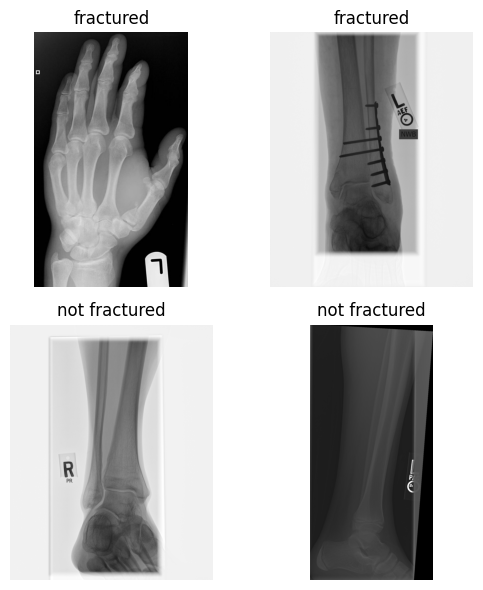

In [ ]:
# preview a couple of images per class
classes=os.listdir(train_dir)
plt.figure(figsize=(6,6))
for i,cls in enumerate(classes):
    path_class=os.path.join(train_dir,cls)
    images=os.listdir(path_class)[:2]
    print(images)
    for x,img_name in enumerate(images):
        img_path=os.path.join(path_class,img_name)
        img=Image.open(img_path)
        plt.subplot(2,2,i*2+x+1)
        plt.imshow(img,cmap="gray")
        plt.title(f"{cls}")
        plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# find & move corrupted images 
ImageFile.LOAD_TRUNCATED_IMAGES=False

def find_bad_images(root_dir):
    bad_files = []
    for root, _, files in os.walk(root_dir):
        for name in files:
            path = os.path.join(root, name)
            ext = os.path.splitext(name)[1].lower()
            if ext not in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
                continue

            try:
                img = Image.open(path)
                img.verify()
                img.close()

                img = Image.open(path)
                img.load()
            except Exception as e:
                bad_files.append(path)

    return bad_files

In [6]:
bad_files=find_bad_images(train_dir)
bad_files+=find_bad_images(test_dir)
bad_files+=find_bad_images(val_dir)

In [7]:
import shutil

def move_bad_files(bad_list, dest="bad_images"):
    os.makedirs(dest, exist_ok=True)
    for path in bad_list:
        new_path = os.path.join(dest, os.path.basename(path))
        shutil.move(path, new_path)
        print("Moved bad file:", path)

move_bad_files(bad_files)

In [ ]:
# safe image loader 
IMG_SIZE = 128
def safe_loader(path):
    try:
        img = Image.open(path).convert('RGB')
        return img
    except (OSError, UnidentifiedImageError) as e:
        print(f" Skipped unreadable image: {path} — replaced with black image")
        return Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0,0,0))

In [ ]:
# transforms
train_transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
transforms.RandomHorizontalFlip(p=0.5),
transforms.RandomVerticalFlip(p=0.5),transforms.ColorJitter(brightness=0.02,contrast=0.02,saturation=0.01,hue=0),
transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor(),
transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
# create datasets
train_dataset=datasets.ImageFolder(root=train_dir,transform=train_transform,loader=safe_loader)
val_dataset=datasets.ImageFolder(root=val_dir,transform=transform,loader=safe_loader)
test_dataset=datasets.ImageFolder(root=test_dir,transform=transform,loader=safe_loader)

In [ ]:
# Dataloader
train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=128,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=128,shuffle=False)

In [ ]:
# compute_pos_weight
def compute_pos_weight(dataset):
    labels=[s[1] for s in dataset.samples]
    cnt=Counter(labels)
    neg=cnt.get(0,0)
    pos=cnt.get(1,0)
    if pos==0:
        return torch.tensor(1.0)
    return torch.tensor(max((1.0), neg/pos))

pos_weight=compute_pos_weight(train_dataset).to(torch.device("cuda" if torch.cuda.is_available()
else "cpu"))
print("pos weight",pos_weight)

pos weight tensor(1., device='cuda:0')


Model definition (FractureCNN)

In [12]:
class FractureCNN(nn.Module):
    def __init__(self,num_classes=1):
        super(FractureCNN,self).__init__()
        self.conv1=nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1)
        self.bnorm1=nn.BatchNorm2d(32)

        self.conv2=nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1)
        self.bnorm2=nn.BatchNorm2d(32)
        self.pool1=nn.MaxPool2d(2,2)
        

        self.conv3=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.bnorm3=nn.BatchNorm2d(64)

        self.conv4=nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)
        self.bnorm4=nn.BatchNorm2d(64)
        self.pool2=nn.MaxPool2d(2,2)
        

        self.conv5=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
        self.bnorm5=nn.BatchNorm2d(128)

        self.conv6=nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)
        self.bnorm6=nn.BatchNorm2d(128)
        self.pool3=nn.MaxPool2d(2,2)
        

        self.global_pool=nn.AdaptiveAvgPool2d((1,1))

        self.fc1=nn.Linear(128,256)
        self.fc2=nn.Linear(256,256)
        self.fc3=nn.Linear(256,256)
        self.fc4=nn.Linear(256,256)
        self.output=nn.Linear(256,1)
        self.dropout_fc=nn.Dropout(0.5)

    def forward(self,X):
        #Block1
        X=F.leaky_relu(self.bnorm1(self.conv1(X)))
        X=F.leaky_relu(self.bnorm2(self.conv2(X)))
        X=self.pool1(X)
        
        #Block2
        X=F.leaky_relu(self.bnorm3(self.conv3(X)))
        X=F.leaky_relu(self.bnorm4(self.conv4(X)))
        X=self.pool2(X)
        
        #Block3
        X=F.leaky_relu(self.bnorm5(self.conv5(X)))
        X=F.leaky_relu(self.bnorm6(self.conv6(X)))
        X=self.pool3(X)
        
        X=self.global_pool(X)
        X=X.view(X.size(0), -1)

        X=F.leaky_relu(self.fc1(X))
        X=self.dropout_fc(X)
        X=F.leaky_relu(self.fc2(X))
        X=self.dropout_fc(X)
        X=F.leaky_relu(self.fc3(X))
        X=self.dropout_fc(X)
        X=F.leaky_relu(self.fc4(X))
        X=self.dropout_fc(X)
        X=self.output(X)

        return X

In [13]:
def init_weights(m):
    if isinstance(m,nn.Conv2d):
        nn.init.kaiming_normal_(m.weight,nonlinearity="leaky_relu")
        if m.bias is not None:
            nn.init.constant_(m.bias,0)
        elif isinstance(m,nn.Linear):
            nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias,0)
        elif isinstance(m,nn.BatchNorm2d):
            nn.init.constant_(m.weight,1)
            nn.init.constant_(m.bias,0)
        

In [14]:

for x, y in train_loader:
    print(x.shape, y.shape, y.dtype, torch.unique(y))
    break

torch.Size([128, 3, 128, 128]) torch.Size([128]) torch.int64 tensor([0, 1])


In [15]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=FractureCNN(num_classes=1).to(device)
model.apply(init_weights)

criterion=nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer=torch.optim.AdamW(model.parameters(),lr=0.001)

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,patience=2,min_lr=1e-5)


In [16]:
from sklearn.metrics import accuracy_score

def evaluate(model,loader,device):
    model.eval()
    losses=[]
    preds=[]
    targets=[]
    with torch.no_grad():
        for imgs,labels in loader:
            imgs=imgs.to(device)
            labels=labels.float().unsqueeze(1).to(device)
            out=model(imgs)
            loss=criterion(out,labels)
            losses.append(loss.item())
            probs=torch.sigmoid(out).detach().cpu().numpy().reshape(-1)
            preds+=(probs>0.5).astype(int).tolist()
            targets+=labels.detach().cpu().numpy().reshape(-1).astype(int).tolist()
            avg_loss=np.mean(losses)
            acc=accuracy_score(targets,preds)
            return avg_loss , acc


Training loop

In [17]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
num_epochs=15


for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    batch_preds, batch_targets = [], []

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(imgs)   
        loss = criterion(outputs, labels)
        loss.backward()
    
        optimizer.step()

        batch_losses.append(loss.item())
        probs = torch.sigmoid(outputs).detach().cpu().numpy().reshape(-1)
        batch_preds += (probs > 0.5).astype(int).tolist()
        batch_targets += labels.detach().cpu().numpy().reshape(-1).astype(int).tolist()

    train_loss = np.mean(batch_losses)
    train_acc = accuracy_score(batch_targets, batch_preds)
    val_loss, val_acc = evaluate(model, val_loader, device)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]  train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}")


Epoch [1/15]  train_loss: 0.5498  val_loss: 0.3066  val_acc: 0.8281
Epoch [2/15]  train_loss: 0.4294  val_loss: 0.4441  val_acc: 0.6484
Epoch [3/15]  train_loss: 0.3585  val_loss: 0.2531  val_acc: 0.9219
Epoch [4/15]  train_loss: 0.2911  val_loss: 0.2357  val_acc: 0.9375
Epoch [5/15]  train_loss: 0.2432  val_loss: 0.1416  val_acc: 0.9531
Epoch [6/15]  train_loss: 0.2177  val_loss: 0.7249  val_acc: 0.7500
Epoch [7/15]  train_loss: 0.1735  val_loss: 0.3549  val_acc: 0.8906
Epoch [8/15]  train_loss: 0.1670  val_loss: 0.2257  val_acc: 0.9297
Epoch [9/15]  train_loss: 0.1356  val_loss: 0.2584  val_acc: 0.8984
Epoch [10/15]  train_loss: 0.0988  val_loss: 0.2541  val_acc: 0.9219
Epoch [11/15]  train_loss: 0.1038  val_loss: 0.2011  val_acc: 0.9531
Epoch [12/15]  train_loss: 0.0712  val_loss: 0.2234  val_acc: 0.9453
Epoch [13/15]  train_loss: 0.0592  val_loss: 0.1455  val_acc: 0.9375
Epoch [14/15]  train_loss: 0.0445  val_loss: 0.1756  val_acc: 0.9453
Epoch [15/15]  train_loss: 0.0623  val_loss

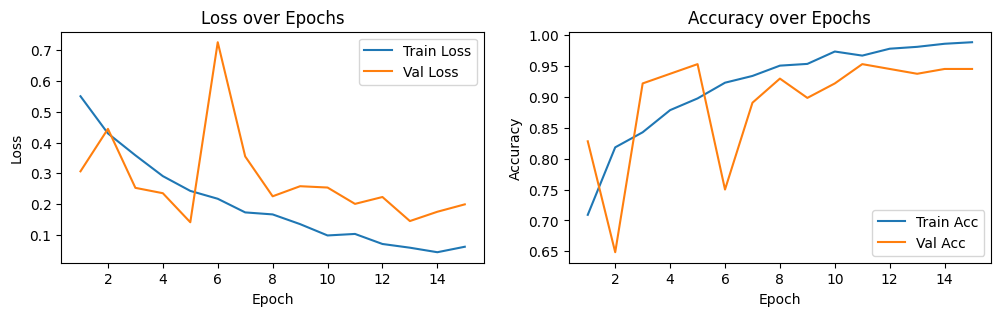

In [ ]:
# plot training curves
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(epochs,train_losses, label='Train Loss',)
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

final testing + confusion matrix

In [22]:
def test_model(model, test_loader, device):
    model.eval()  
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(imgs)
            probs = torch.sigmoid(outputs)          
            preds = (probs > 0.5).int()              

            all_preds += preds.cpu().numpy().tolist()
            all_targets += labels.cpu().numpy().tolist()

    acc = accuracy_score(all_targets, all_preds)
    print("Test Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(all_targets, all_preds))

    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    return all_targets, all_preds

Test Accuracy: 0.966

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       238
         1.0       0.98      0.96      0.97       262

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



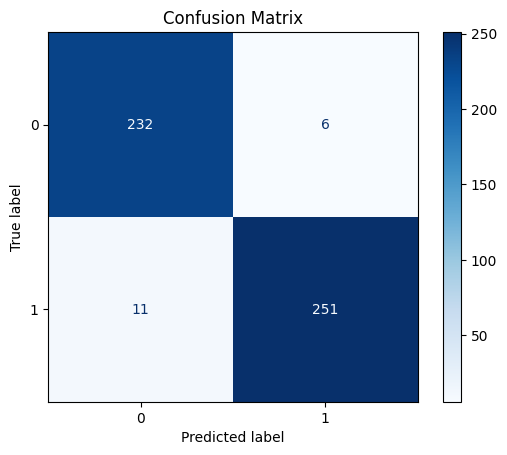

In [23]:
all_targets, all_preds = test_model(model, test_loader, device)